In [11]:
import matplotlib
#matplotlib.use('Agg')
%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


colors = [    
'orange','firebrick','lawngreen','dodgerblue','crimson','orchid','slateblue',
'darkgreen','darkorange','indianred','darkviolet','deepskyblue','greenyellow',
'peru','cadetblue','forestgreen','slategrey','lightsteelblue','rebeccapurple',
'darkmagenta','yellow','hotpink']


Autosaving every 180 seconds


In [2]:
from moviepy.editor import VideoFileClip
import numpy as np
from pathlib import Path
from skimage.util import img_as_ubyte
import tensorflow as tf
import tensorflow.contrib.slim as slim
#import tf_slim as slim
from tqdm import tqdm
import yaml
from deeplabcut.pose_estimation_tensorflow.nnet.net_factory import pose_net
from util import create_annotated_movie, get_train_config
from deeplabcut.pose_estimation_tensorflow.nnet.pose_net import prediction_layer
from deeplabcut.utils import auxiliaryfunctions

vers = tf.__version__.split('.')
if int(vers[0]) == 1 and int(vers[1]) > 12:
    TF = tf.compat.v1
else:
    TF = tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:

# %% util functions
def calculate_peaks(numparts, heatmap_avg):
    # Right now there is a score for every part since some parts are likely to need lower thresholds.
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        ##logger.ERROR('Not enough scores provided for number of parts')
        # return
    # threshold_detection = params['thre1']
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[:, :, part]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks


def zero2nan(x):
    x1 = np.copy(x)
    x1[np.sum(x, 1) == 0, :] = np.nan
    return x1


def temporal_filter_first(markers, na, adds):
    # filter the traces for the first time
    markers_temp = np.copy(markers)
    markers_filter = np.copy(markers_temp)
    end_frame = markers_temp.shape[0]
    wt_bound = 20  # upper bound of the distance that a marker can move between two frames
    cl_bound = 0.7  # lower bound of the confidence level
    part_id = 0
    for animal_id in range(na + adds):  #
        marker_previous = markers_temp[0, animal_id, 0, :]
        for frame_id in range(1, end_frame):
            cl = markers_cen[frame_id, :, :, 0]  # confidence level

            marker_current = markers_temp[frame_id, :, part_id, :]
            marker_current = zero2nan(marker_current)  # set zeros to nans

            marker_previous1 = marker_previous.reshape(1, -1)
            marker_previous1 = zero2nan(marker_previous1)[0]  # set zeros to nans

            move_marker = []
            for marker_i in marker_current:
                move_marker_i = np.sqrt(np.sum((marker_i[1:] - marker_previous1[1:]) ** 2))
                move_marker += [np.sum(move_marker_i)]
            move_marker = np.array(move_marker)
            move_marker[np.isnan(move_marker)] = 1e10  # if the movement is nan, set it to be 1e10
            move_marker_valid_ind = np.where(move_marker <= wt_bound)[0]  # pick the ids whose movement is below wt_bound
            if len(move_marker_valid_ind) == 0:  # if all movements are not valid
                marker_i = marker_previous1
            else:
                cl_valid = cl[move_marker_valid_ind]
                cl_valid_ind = np.where(cl_valid > cl_bound)[0]
                if len(cl_valid_ind) == 0:  # if all of the confidence levels are below 0.7, pick the id with the highest confidence level
                    selected_id = np.argmax(cl_valid)
                    selected_id = move_marker_valid_ind[selected_id]
                else:  # for all confidence levels which are above 0.7, pick the id with the smallest movement
                    move_marker_valid_cl = move_marker_valid_ind[cl_valid_ind]
                    move_marker_valid_cl_ind = move_marker[move_marker_valid_cl]
                    selected_id = np.argmin(move_marker_valid_cl_ind)
                    selected_id = move_marker_valid_cl[selected_id]

                marker_i = marker_current[selected_id, :]
                markers_temp[frame_id, selected_id, part_id, :] = np.nan  # set the identity to be nan if it's already selected

            marker_previous = np.copy(marker_i)
            markers_filter[frame_id, animal_id, part_id, :] = marker_i

    return markers_filter


def temporal_filter_second(markers, na, adds):
    # filter the traces for the second time
    markers_filter = np.copy(markers)
    end_frame = markers_filter.shape[0]
    wt_bound = 20
    cl_bound = 0.7  # lower bound of the confidence level
    part_id = 0
    marker_previous = markers_filter[0, :, part_id, :]
    candidate_id = -np.ones((na + adds, na + adds))
    candidate_id[:, 0] = np.linspace(0, na + adds - 1, na + adds).astype(np.int32)
    candidate_move = candidate_id * 0
    for frame_id in range(1, end_frame):
        cl = markers[frame_id, :, :, 0]
        candidate_id_new = candidate_id.copy()
        for animal_id in range(na + adds):  # [0,1]:#
            marker_current = markers[frame_id, :, part_id, :]
            marker_current = zero2nan(marker_current)  # set zeros to nans

            marker_previous1 = marker_previous[animal_id, :].reshape(1, -1)
            marker_previous1 = zero2nan(marker_previous1)[0]  # set zeros to nans

            move_marker = []
            for marker_i in marker_current:
                move_marker_i = np.sqrt(np.sum((marker_i[1:] - marker_previous1[1:]) ** 2))
                move_marker += [np.sum(move_marker_i)]
            move_marker = np.array(move_marker)
            move_marker[np.isnan(move_marker)] = 1e10  # if the movement is nan, set it to be 1e10
            move_marker_valid_ind = np.where(move_marker <= wt_bound)[0]  # pick the ids whose movement is below wt_bound
            if len(move_marker_valid_ind) > 0:  # if at least one of the movements is valid
                cl_valid = cl[move_marker_valid_ind]
                cl_valid_ind = np.where(cl_valid > cl_bound)[0]
                if len(cl_valid_ind) == 0:  # if all of the confidence levels are below 0.7, pick the id with the highest confidence level
                    selected_id_sortlist = np.argsort(-cl_valid)
                    selected_id_sortlist = move_marker_valid_ind[selected_id_sortlist]
                else:
                    move_marker_valid_cl = move_marker_valid_ind[cl_valid_ind]
                    move_marker_valid_cl_ind = move_marker[move_marker_valid_cl]
                    selected_id_sortlist = np.argsort(move_marker_valid_cl_ind)
                    selected_id_sortlist = move_marker_valid_cl[selected_id_sortlist]

                candidate_id[animal_id, :len(selected_id_sortlist)] = selected_id_sortlist.reshape(-1, )
                candidate_id[animal_id, len(selected_id_sortlist):] = -1

            # based on the candidate id list, make a candidate movement list
            candidate_move_list = move_marker * 0 + 1e10
            for can_j, can_move in enumerate(candidate_id[animal_id, :]):
                if can_move > -1:
                    candidate_move_list[can_j] = move_marker[int(can_move)]
            candidate_move[animal_id, :] = candidate_move_list

        # based on the movement from time t-1 to time t for each id, we can assign ids at t-1 to ids at t
        # we need to make sure: 1. each id at t-1 is only assigned to id at t once, making sure no two ids share the same id at t-1
        #                       2. when two ids at t compete for one id at t-1, the one with the smallest movement will get the assignment
        assigned_list = []
        unique_list = []
        # go over each column from left to right, left has the highest priority
        for c in range(candidate_id.shape[1]):
            candidate_column = candidate_id[:, c]

            # count the occurrence of each id in column c
            uniques, counts = np.unique(candidate_column, return_counts=True)

            # throw away -1
            u1 = np.where(uniques > -1)[0]
            uniques = uniques[u1]
            counts = counts[u1]

            # get the ids who only appear once
            unique_one = uniques[np.where(counts == 1)[0]]
            for uo in unique_one:
                if uo not in unique_list:
                    candidate_uo = np.where(candidate_column == uo)[0][0]
                    if candidate_uo not in assigned_list:
                        candidate_id_new[candidate_uo, :] = uo
                        assigned_list += [candidate_uo]

            # get the ids who appear twice or more
            unique_tm = uniques[np.where(counts > 1)[0]]
            for utm in unique_tm:
                if utm not in unique_list:
                    candidate_utm = np.where(candidate_column == utm)[0]
                    candidate_utm = list(candidate_utm)
                    candidate_move_c = candidate_move[:, c].copy()  # get the candidate movement in column c
                    candidate_move_c[assigned_list] = 1e10  # if one id is already assigned, set the move to be 1e10
                    candidate_move_utm = candidate_move_c[candidate_utm]
                    min_ind = np.argmin(candidate_move_utm)
                    candiate_utm_min = candidate_utm[min_ind]
                    if candiate_utm_min not in assigned_list:
                        candidate_id_new[candiate_utm_min, 0] = utm
                        assigned_list += [candiate_utm_min]

            unique_list += list(uniques)

        full_list = list(range(na + adds))
        not_assigned_list = [v for v in full_list if v not in assigned_list]

        assigned_id = candidate_id_new[assigned_list, 0]
        not_assigned_id = [v for v in full_list if v not in assigned_id]
        candidate_id_new[not_assigned_list, 0] = not_assigned_id
        candidate_id_new[:, 1:] = -1
        candidate_id = candidate_id_new

        marker_previous = marker_current[np.array(candidate_id[:, 0]).astype(np.int32), :]
        markers_filter[frame_id, :, part_id, :] = marker_previous

    return markers_filter

In [4]:
# %%
# snapshot from DLC
snapshot = 'snapshot-100000'
# project path
dlcpath = '/media/cat/4TBSSD/DLC_full_directory'
# the path to the test video
test_video = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'

shuffle = 1
dlc_base_path = Path(dlcpath)
config_path = dlc_base_path / 'config.yaml'
print('config_path', config_path)
cfg = auxiliaryfunctions.read_config(config_path)
trainingsetindex = 0
modelfoldername = auxiliaryfunctions.GetModelFolder(
    cfg["TrainingFraction"][trainingsetindex], shuffle, cfg)

train_path = dlc_base_path / modelfoldername / 'train'
init_weights = str(train_path / snapshot)

# structure info
bodyparts = cfg['multianimalbodyparts']
skeleton = cfg['skeleton']
if skeleton is None:
    skeleton = []
S0 = np.zeros((len(skeleton), len(bodyparts)))
for s in range(len(skeleton)):
    sk = skeleton[s]
    ski = bodyparts.index(sk[0])
    skj = bodyparts.index(sk[1])
    S0[s, ski] = 1
    S0[s, skj] = -1

na = 4  # number of animals
nl = len(skeleton)
nj = len(bodyparts)

# %%
video_clip = VideoFileClip(test_video)
ny_in, nx_in = video_clip.size
n_frames = np.ceil(video_clip.fps * video_clip.duration).astype('int')
print('done')

# load dlc project config file
print('loading dlc project config...', end='')
with open(config_path, 'r') as stream:
    proj_config = yaml.safe_load(stream)
proj_config['video_path'] = None
dlc_cfg = get_train_config(proj_config, shuffle=1)
dlc_cfg.init_weights = init_weights
dlc_cfg.net_type = 'resnet_50'
print(dlc_cfg)
print('dlc_cfg.init_weights', dlc_cfg.init_weights)




config_path /media/cat/4TBSSD/DLC_full_directory/config.yaml
done
loading dlc project config.../media/cat/4TBSSD/DLC_full_directory/dlc-models/iteration-0/madeline_july2Jul2-trainset95shuffle1/train/pose_cfg.yaml
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': '/media/cat/4TBSSD/DLC_full_directory/dlc-models/iteration-0/madeline_july2Jul2-trainset95shuffle1/train/snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True, 'optimizer': 'adam', 'intermediate_supervision': False, 'intermediate_supervision_layer': 12, 'regularize': False, 'weight_decay': 0.0001, 'crop_pad': 0, 'scoremap_dir': 'test', 'batch_size': 8, 'dataset_type': 'multi-animal-imgaug', 'deterministic': False, 'mirror': False, 'pairwise_huber_loss': False, 'weigh_only_present_joints': False, 'partaffi

In [7]:

# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session
config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())

# restore resnet from dlc trained weights
restorer.restore(sess, dlc_cfg.init_weights)

# %% collect traces for test video
# -------------------
# extract pose
# -------------------
print('\n')
n_frames = 1000
print ("overwrting # frames: ", n_frames)

pbar = tqdm(total=n_frames, desc='processing video frames')
adds = 10  # additional markers to be identified


markers = np.zeros((n_frames, na + adds, nj, 3))

centroids = np.arange(14)
#for centroid in centroids:
#centroid = 4  # pick the 7th marker as the centroid

for i in range(n_frames):
    if i%50==0:
        print ("frame; ", i)
    pred_s= predictions[i][None]


    nx_out = pred_s.shape[1]
    ny_out = pred_s.shape[2]
    sig_pred = 1 / (np.exp(-pred_s) + 1)  # confidence map

    # find peaks from the confidence map
    all_peaks = calculate_peaks(nj, sig_pred[0, :, :, :])
    for ind, peak_i in enumerate(all_peaks):
        if len(peak_i) > 0:# and ind == centroid:
            peak_i = np.array(peak_i)
            peak_i1 = np.argsort(peak_i[:, 2])
            peak_i = peak_i[peak_i1, :]
            len_peak = len(peak_i)
            if len_peak < na + adds:
                peak_i = np.vstack((np.zeros((na + adds - len_peak, 4)), peak_i))
            peak_i = peak_i[(-na - adds):, :]
            peak_i = peak_i[:, :3]
            peak_i = np.flip(peak_i, 0)
            markers[i, :, ind, :] = peak_i

   #pbar.update()

markers = np.flip(markers, 3)
    


Initializing ResNet



processing video frames:   0%|          | 0/1000 [00:07<?, ?it/s]



overwrting # frames:  1000


In [6]:
predictions = np.load('/media/cat/4TBSSD/DLC_full_directory/videos_to_label/predictions.npy')
print (predictions.shape)
print (markers.shape)
#print (markers[0])

(1000, 128, 160, 14)
(1000, 14, 14, 3)


In [9]:

# %%
# filter the traces for the first time
print ("Filtering traces")
tracesx = []
tracesy = []

centroids = np.arange(14)
for centroid in centroids:
    print ("centroid: ", centroid)
    markers_cen = markers[:, :, centroid, None, :]
    print ("markers_cen ", markers_cen.shape)
    markers_filter = temporal_filter_first(markers_cen, na, adds)

    # %% find the top na traces with the highest confidence levels
    print ("Searching for highest confidence")
    top_n = na
    markers_filter_cl = np.mean(markers_filter, 0)
    markers_filter_cl = np.squeeze(markers_filter_cl[:, :, 0])  # confidence level for each trace
    argsort_ind = np.argsort(-markers_filter_cl)  # ind from high confidence level to low
    argsort_ind = argsort_ind[:top_n]
    markers_filter_cl1 = markers_filter_cl[argsort_ind]
    markers_filter1 = markers_filter[:, argsort_ind, :, :]

    # %%
    # filter the traces for the second time. This is mainly for finetune the filtering to prevent swapping
    print ("filter2")
    markers_filter1[:, :, :, 0] = 1
    markers_filter2 = temporal_filter_second(markers_filter1, na, 0)

    # %% make movie with traces
    markers_joint = np.reshape(markers_filter2[:, :, :, 1:], [markers_filter2.shape[0], -1, 2]) * 8 + 4

    # -------------------
    # save labels
    # -------------------
    tracesx.append(markers_joint[:, :, 1].T)
    tracesy.append(markers_joint[:, :, 0].T)
 
print ("DONE")   

#deo_clip = VideoFileClip(str(test_video))

# # make movie
# print ("Making video")
# create_annotated_movie(
#     video_clip,
#     labels['x'],
#     labels['y'],
#     filename=test_video[:-4] + '_label.mp4', dotsize=15, colormap='jet')

# video_clip.close()

Filtering traces
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confidence
filter2
markers_cen  (1000, 14, 1, 3)
Searching for highest confiden

In [14]:
print ("tracesx: ", tracesx[0].shape)
print (len(tracesx))
print (np.max(tracesx[0]), np.min(tracesx[0]))

tracesx:  (4, 1000)
14
1276.0 60.0


In [24]:
print (dlc_cfg.all_joints_names)

['nose', 'lefteye', 'righteye', 'leftear', 'rightear', 'spine1', 'spine2', 'spine3', 'spine4', 'spine5', 'tail1', 'tail2', 'tail3', 'tail4']


In [59]:
import cv2

# OPTIONAL MAKE VIDEO TO REVIEW ASSEMBLED VS. INFERENCE LABELS (PRE-FIX)
# colors have weird inversion; red is blue and cyan is yellow
colors_4 = ['blue','red','cyan','green']

video_name = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'
original_vid = cv2.VideoCapture(video_name)

# video sizes
size_vid = np.array([1280,1024])
scale = 4
dot_size = 30

#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fourcc = cv2.VideoWriter_fourcc('M','P','E','G')

vids_out = []
for k in range(14):
    fname_out = video_name[:-4]+"_feature_"+str(k).zfill(2)+".mp4"
    vids_out.append(cv2.VideoWriter(fname_out,fourcc, 15, (1280,1024), True))

#dot_size = 10//scale
# setup cutoff 
pcutoff = 0.01

font = cv2.FONT_HERSHEY_PLAIN

# go through first videos
from tqdm import trange

#original_vid.set(cv2.CAP_PROP_POS_FRAMES, start)

for n in trange(0, tracesx[0].shape[1], 1):
#for n in trange(0, 50, 1):
    ret, frame = ret, frame = original_vid.read()
    #print ("frame:", frame.shape)

    for z in range(len(tracesx)):
        frame_copy = frame.copy()
        for a in range(tracesx[z].shape[0]):
            x = int(tracesx[z][a,n])
            y = int(tracesy[z][a,n])

            if np.isnan(x) or np.isnan(y):
                pass
            else:
                frame_copy[y-dot_size:y+dot_size,x-dot_size:x+dot_size]= (np.float32(
                    #matplotlib.colors.to_rgb(colors[z//14]))*255.).astype('uint8')
                    matplotlib.colors.to_rgb(colors[a]))*255.).astype('uint8')

        #cv2.putText(frame_copy, text,location,  font,font size, font color,    font weight, line)\n",
        if z==0:
            cv2.putText(frame_copy, str(n), (150, 105), font, 5, (255, 255, 0), 5)
    
        cv2.putText(frame_copy, dlc_cfg.all_joints_names[z], (150, 150), font, 5, (255, 255, 0), 5)
    
        vids_out[z].write(frame_copy)
    
    #print ("")

for k in range(14):
    #fname_out = video_name[:-4]+"_feature_"+str(k)+".mp4"
    vids_out[k].release()
original_vid.release()

100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


In [60]:
texts = [
'ffmpeg -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_00.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_01.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_02.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_03.mp4 -filter_complex "[0:v]crop=1070:750:150:50[left1];  [1:v]crop=1070:750:150:50[left2]; [2:v]crop=1070:750:150:50[left3]; [3:v]crop=1070:750:150:50[left4]; [left1][left2][left3][left4]hstack=4" /home/cat/vid1234.avi ',
'ffmpeg -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_04.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_05.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_06.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_07.mp4 -filter_complex "[0:v]crop=1070:750:150:50[left1];  [1:v]crop=1070:750:150:50[left2]; [2:v]crop=1070:750:150:50[left3]; [3:v]crop=1070:750:150:50[left4]; [left1][left2][left3][left4]hstack=4" /home/cat/vid5678.avi ',
'ffmpeg -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_08.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_09.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_10.mp4 -i /media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec_feature_11.mp4 -filter_complex "[0:v]crop=1070:750:150:50[left1];  [1:v]crop=1070:750:150:50[left2]; [2:v]crop=1070:750:150:50[left3]; [3:v]crop=1070:750:150:50[left4]; [left1][left2][left3][left4]hstack=4" /home/cat/vid9101112.avi ',

'ffmpeg -i /home/cat/vid1234.avi -i /home/cat/vid5678.avi -i /home/cat/vid9101112.avi  -filter_complex "[0:v][1:v][2:v]vstack=inputs=3[v]" -map "[v]" /home/cat/all.avi '
]

import os
for text in texts:
    os.system(text) 



In [5]:

# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session
config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())

# restore resnet from dlc trained weights
restorer.restore(sess, dlc_cfg.init_weights)

# %% collect traces for test video
# -------------------
# extract pose
# -------------------
print('\n')
pbar = tqdm(total=n_frames, desc='processing video frames')
adds = 10  # additional markers to be identified

#n_frames = 100

markers = np.zeros((n_frames, na + adds, nj, 3))
centroid = 6  # pick the 7th marker as the centroid
#for i in range(n_frames):
i = 0

# scoop out the rock in each frame
frame = video_clip.get_frame(i / video_clip.fps)
ff = img_as_ubyte(frame)
ws1 = 60
ws2 = 40
patch = [132, 1080]
ff_mask = np.zeros((ff.shape))
ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] = ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] + 1
ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] = ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] + 1
ff_mask = -np.sign(ff_mask - 2)
ff = ff * ff_mask

# feed to the network
feed_dict = {inputs: ff[None, :, :, :]}
[pred_s] = sess.run([pred], feed_dict=feed_dict)
nx_out = pred_s.shape[1]
ny_out = pred_s.shape[2]
sig_pred = 1 / (np.exp(-pred_s) + 1)  # confidence map



Initializing ResNet


processing video frames:   0%|          | 0/1500 [00:00<?, ?it/s]

In [9]:
from skimage.util import img_as_ubyte
from moviepy.editor import VideoFileClip


# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session
config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())

# restore resnet from dlc trained weights
restorer.restore(sess, dlc_cfg.init_weights)

video_clip = VideoFileClip('/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi')

n_frames = 10
threshold=0.4
x1, x2 = 80,800
y1, y2 = 120, 1200

surfaces = np.zeros((n_frames,90,135),'float32')
predictions = np.zeros((n_frames,128,160,14),'float32')
for n in range(n_frames):
    # scoop out the rock in each frame
    frame = video_clip.get_frame(n / video_clip.fps)
    ff = img_as_ubyte(frame)

    # feed to the network
    print ("Img #: ", n)
    feed_dict = {inputs: ff[None, :, :, :]}
    
    [pred_s] = sess.run([pred], feed_dict=feed_dict)
    
    predictions[n] = pred_s.squeeze()
    
    print (pred_s.shape)
    print ("make img")
    sums = np.zeros((90,135),'float32')
    for k in range(14):
        temp= pred_s.squeeze()[:,:,k][x1//8:x2//8, y1//8:y2//8]
        temp = (temp -np.min(temp))/ (np.max(temp)-np.min(temp))

        idx = np.where(temp<threshold)
        temp[idx]=0
        sums+=temp
    surfaces[n]= sums

Initializing ResNet
Img #:  0
(1, 128, 160, 14)
make img
Img #:  1
(1, 128, 160, 14)
make img
Img #:  2


KeyboardInterrupt: 

In [12]:
plt.imshow(surfaces[0])
plt.savefig('/home/cat/surface.png')
plt.close()

plt.imshow(predictions[0].sum(2))
plt.savefig('/home/cat/predictions.png')
plt.close()

In [67]:
#
import cv2
print (surfaces.shape)

video_name = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'

#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fname_out = video_name[:-4]+"_corrected.avi"

fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
#fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_out = cv2.VideoWriter(fname_out,fourcc, 30, (surfaces.shape[2],surfaces.shape[1]), True)

for n in range(surfaces.shape[0]):
    
    #print ("")
    #img = np.ones((500, 500, 3), dtype=np.uint8)*i
    temp = surfaces[n].T*256
    
    frame = np.uint8(np.array((temp,temp,temp*0))).T
    print (frame.shape)
#     frame = np.random.randint(0, 256, 
#                               (surfaces.shape[2],surfaces.shape[1], 3), 
#                               dtype=np.uint8)
    print (frame.shape)
    video_out.write(frame)
    print ('')

 

video_out.release()


(100, 90, 135)
(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)
(90, 135, 3)

(90, 135, 3)


In [11]:
#d = start+5000

# # Add fixed labels to video:
# reassembled = np.load('/media/cat/4TBSSD/dan/march_2/madeline_dlc/march_16/2020-3-16_12_54_07_193951_compressed/2020-3-16_12_54_07_193951_compressedvideo_labeled_exported_fixed_interpolated_10.npz')
# tracesx_re = reassembled['tracesx_interpolated']
# tracesy_re = reassembled['tracesy_interpolated']
# start = 0
# end = tracesx_re.shape[0]
# #end = 1000
# print (tracesx_re.shape)

import cv2

# %%
# -------------------
# define model
# -------------------
# sess, net, inputs = initialize_resnet(dlc_cfg, nx_in, ny_in)
TF.reset_default_graph()
inputs = TF.placeholder(tf.float32, shape=[None, None, None, 3])
pn = pose_net(dlc_cfg)

net, end_points = pn.extract_features(inputs)
scope = "pose"
reuse = None
heads = {}
with tf.variable_scope(scope, reuse=reuse):
    heads["part_pred"] = prediction_layer(
        dlc_cfg, net, "part_pred", nj
    )
    heads["locref"] = prediction_layer(
        dlc_cfg, net, "locref_pred", nj * 2
    )

    heads["pairwise_pred"] = prediction_layer(
        dlc_cfg, net, "pairwise_pred", nl * 2
    )
pred = heads['part_pred']

# restore from snapshot
variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
variables_to_restore1 = slim.get_variables_to_restore(include=["pose/part_pred"])
restorer = TF.train.Saver(variables_to_restore + variables_to_restore1)

# initialize tf session

config_TF = TF.ConfigProto()
config_TF.gpu_options.allow_growth = True
sess = TF.Session(config=config_TF)

# initialize weights
sess.run(TF.global_variables_initializer())
sess.run(TF.local_variables_initializer())


# OPTIONAL MAKE VIDEO TO REVIEW ASSEMBLED VS. INFERENCE LABELS (PRE-FIX)
# colors have weird inversion; red is blue and cyan is yellow
colors_4 = ['blue','red','cyan','green']

video_name = '/media/cat/4TBSSD/DLC_full_directory/videos_to_label/2020-3-16_12_54_07_193951_compressed_60sec.avi'
original_vid = cv2.VideoCapture(video_name)

# video sizes
size_vid = np.array([1280,1024])
scale = 4
dot_size = 16//scale

#out_dir = '/media/cat/4TBSSD/dan/march_2/madeline_dlc/2020-3-9_08_18_49_128168/'
fname_out = video_name[:-4]+"_corrected.mp4"
fourcc = cv2.VideoWriter_fourcc('M','P','E','G')
video_out = cv2.VideoWriter(fname_out,fourcc, 25, (135,90), True)

#dot_size = 10//scale
# setup cutoff 
pcutoff = 0.01

# go through first videos
from tqdm import trange

#original_vid.set(cv2.CAP_PROP_POS_FRAMES, start)

x1, x2 = 80,800
y1, y2 = 120, 1200

for n in trange(0, 10, 1):
    
    
     # scoop out the rock in each frame
    frame = video_clip.get_frame(n / video_clip.fps)
    ff = img_as_ubyte(frame)
    ws1 = 60
    ws2 = 40
    patch = [132, 1080]
    ff_mask = np.zeros((ff.shape))
    ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] = ff_mask[(patch[0] - ws1):(patch[0] + ws1), :, :] + 1
    ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] = ff_mask[:, (patch[1] - ws2):(patch[1] + ws2), :] + 1
    ff_mask = -np.sign(ff_mask - 2)
    ff = ff * ff_mask

    # feed to the network
    feed_dict = {inputs: ff[None, :, :, :]}
    [pred_s] = sess.run([pred], feed_dict=feed_dict)
    
    
#     frame = video_clip.get_frame(i / video_clip.fps)
#     print (frame.shape)
#     print (pred_s.shape)
#     ax=plt.subplot(4,4,15)
#     x1, x2 = 80,800
#     y1, y2 = 120, 1200
#     plt.imshow(frame[x1:x2,y1:y2])

    sums = np.zeros((90,135),'float32')
    for k in range(14):
        ax=plt.subplot(4,4,k+1)
        #plt.title(bodyparts[k])

        temp= pred_s.squeeze()[:,:,k][x1//8:x2//8, y1//8:y2//8]
        temp = (temp -np.min(temp))/ (np.max(temp)-np.min(temp))

        idx = np.where(temp<0.4)
        temp[idx]=0

        sums+=temp
    
    #print ("")
    print (sums.shape)
    sums = np.uint8(sums)
    video_out.write(sums)

    #print ("")

video_out.release()
original_vid.release()



Initializing ResNet


  0%|          | 0/10 [00:00<?, ?it/s]WARNING:py.warnings:/home/cat/.conda/envs/DLC-GPU/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

 10%|█         | 1/10 [00:00<00:04,  1.90it/s]

(90, 135)


 20%|██        | 2/10 [00:00<00:03,  2.30it/s]

(90, 135)


 30%|███       | 3/10 [00:00<00:02,  2.72it/s]

(90, 135)


 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

(90, 135)


 50%|█████     | 5/10 [00:01<00:01,  3.45it/s]

(90, 135)


 60%|██████    | 6/10 [00:01<00:01,  3.74it/s]

(90, 135)


 70%|███████   | 7/10 [00:01<00:00,  3.94it/s]

(90, 135)


 80%|████████  | 8/10 [00:02<00:00,  4.15it/s]

(90, 135)


 90%|█████████ | 9/10 [00:02<00:00,  4.20it/s]

(90, 135)


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

(90, 135)


In [3]:
data = np.load('/media/cat/4TBSSD/felix/tmp/nn_train/cluster/templates.npy')
print (data.shape)

(1246, 101, 934)


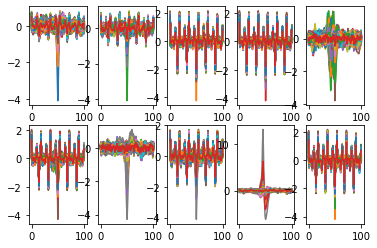

In [5]:
import matplotlib.pyplot as plt
for k in range(10):
    ax=plt.subplot(2,5,k+1)
    plt.plot(data[k])
plt.show()

(1000, 128, 160, 14)
